<a href="https://colab.research.google.com/github/deigo-lps/Image-Processing/blob/main/Atividade1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image,ImageDraw
import numpy as np
import math
import random
dimensao_imagem = 256

In [ ]:
def cria_imagem(quantidade_de_quadrados, dimensao_imagem, brilho_inicial):
    img = Image.new('L', (dimensao_imagem, dimensao_imagem))
    array_imagem = np.array(img)
    brilho = brilho_inicial
    aumento_brilho = brilho_inicial/quantidade_de_quadrados
    dimensao_quadrado = int(dimensao_imagem/math.sqrt(quantidade_de_quadrados))
    for i in range(dimensao_quadrado, dimensao_imagem+1, dimensao_quadrado):
        for j in range(dimensao_quadrado, dimensao_imagem+1, dimensao_quadrado):
            array_imagem[i-dimensao_quadrado:i, j-dimensao_quadrado:j] = brilho
            brilho = brilho + aumento_brilho
    img = Image.fromarray(array_imagem)
    img.show()
    return array_imagem

Imagens criadas com a biblioteca Pillow no modo L (Luminance) tem uma taxa de amostragem de 8bits.
https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes

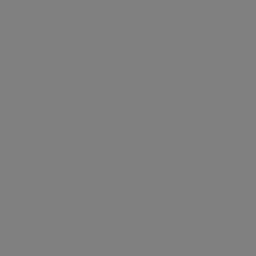

In [ ]:
img1 = cria_imagem(1, dimensao_imagem, 128)

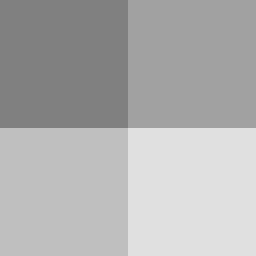

In [ ]:
img2 = cria_imagem(4, dimensao_imagem, 128)

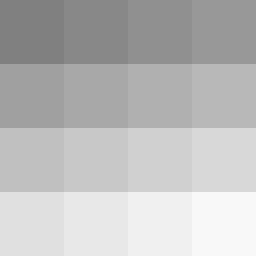

In [ ]:
img3 = cria_imagem(16, dimensao_imagem, 128)

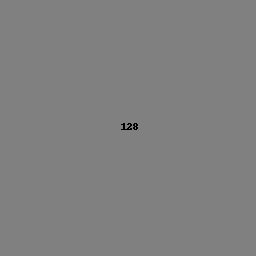

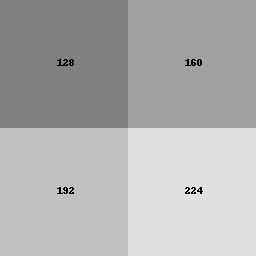

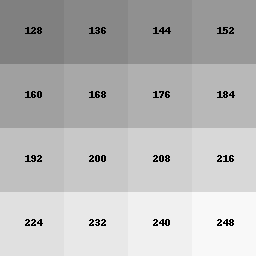

In [ ]:

def label_sectors(img,sectors,brilho_inicial):
  txt_img = Image.new('RGBA', (dimensao_imagem, dimensao_imagem), (255, 255, 255, 0))
  draw = ImageDraw.Draw(txt_img)
  aumento_brilho = int(brilho_inicial/sectors)
  sectors = int(dimensao_imagem/math.sqrt(sectors))
  for i in range(sectors,dimensao_imagem+1,sectors):
    for j in range(sectors,dimensao_imagem+1,sectors):
      x = j - sectors // 2
      y = i - sectors // 2
      draw.text((x-7, y-7), str(brilho_inicial), fill=(0, 0, 0, 255), anchor="mm")
      brilho_inicial = brilho_inicial + aumento_brilho
  Image.alpha_composite(Image.fromarray(img).convert('RGBA'), txt_img).convert('L').show()

label_sectors(img1,1,128)
label_sectors(img2,4,128)
label_sectors(img3,16,128)


In [ ]:
def hoshen_kopelman(img_array, cor_atual, id_regiao):
    agrupamentos_array = np.zeros((len(img_array), len(img_array))).astype(int)
    agrupamento_atual = id_regiao
    lista_agrupamentos = np.zeros(len(img_array)*len(img_array)).astype(int)
    for i in range(0, len(img_array)*len(img_array)):
        lista_agrupamentos[i] = i
    for x in range(0, len(img_array)):
        for y in range(0, len(img_array)):
            if img_array[x][y] == cor_atual:
                esquerda = agrupamentos_array[x][y-1]
                acima = agrupamentos_array[x-1][y]
                diagonal_sup_esq = agrupamentos_array[x - 1][y-1] if (x-1 >= 0 and y-1 >= 0) else 0
                diagonal_sup_dir = agrupamentos_array[x-1][y+1] if (x-1 >= 0 and y+1 < len(img_array)) else 0
                if esquerda == 0 and acima == 0 and diagonal_sup_esq == 0 and diagonal_sup_dir == 0:
                    agrupamento_atual += 1
                    agrupamentos_array[x][y] = agrupamento_atual
                else:
                    vizinhos = [i for i in [esquerda, acima, diagonal_sup_esq, diagonal_sup_dir] if i != 0]
                    min_vizinho = min(vizinhos)
                    agrupamentos_array[x][y] = min_vizinho
                    for v in vizinhos:
                        if v != min_vizinho:
                            union(min_vizinho, v, lista_agrupamentos)
    return agrupamentos_array

In [ ]:
def encontra_agrupamentos(dimensao_imagem, img_array):
    valores_profundidade = []
    for linha in img_array:
        for valor in linha:
            if not valor in valores_profundidade and valor != 0:
                valores_profundidade.append(valor)

    matriz = np.matrix([[0]*dimensao_imagem]*dimensao_imagem)
    i = 0
    for valor in valores_profundidade:
        matriz = np.matrix(hoshen_kopelman(img2, valor, i)) + matriz
        i += 1
    return matriz, i

In [ ]:
[agrupamentos, num_agrupamentos] = encontra_agrupamentos(dimensao_imagem, img2)
print(agrupamentos)
print("numero de componentes conexos: {}".format(num_agrupamentos))

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [3 3 3 ... 4 4 4]
 [3 3 3 ... 4 4 4]
 [3 3 3 ... 4 4 4]]
numero de componentes conexos: 4


In [ ]:
primeiro_componente = random.randint(1, num_agrupamentos)
segundo_componente = primeiro_componente
while segundo_componente == primeiro_componente:
    segundo_componente = random.randint(1, num_agrupamentos)

def get_center(componente):
    def get_high(componente):
        for i in range(len(agrupamentos)):
            for j in range(len(agrupamentos)):
                if agrupamentos[i, j] == componente:
                    return i, j

    def get_low(componente):
        for i in range(len(agrupamentos)-1, -1, -1):
            for j in range(len(agrupamentos)-1, -1, -1):
                if agrupamentos[i, j] == componente:
                    return i, j

    X_high, Y_high = get_high(componente)
    X_low, Y_low = get_low(componente)
    return (X_high+X_low)/2, (Y_high+Y_low)/2

def euclidiana(primeiro, segundo):
    return math.sqrt((pow(primeiro[0]-segundo[0], 2)+pow(primeiro[1]-segundo[1], 2)))


def d4(primeiro, segundo):
    return abs(primeiro[0]-segundo[0])+abs(primeiro[1]-segundo[1])


def d8(primeiro, segundo):
    return max(abs(primeiro[0]-segundo[0]), abs(primeiro[1]-segundo[1]))

print("Distancias entre centro dos componentes {} e {}:".format(
    primeiro_componente, segundo_componente))
print("De: {}.".format(euclidiana(
    get_center(primeiro_componente),
    get_center(segundo_componente)
)))
print("D4: {}.".format(d4(
    get_center(primeiro_componente),
    get_center(segundo_componente)
)))
print("D8: {}.".format(d8(
    get_center(primeiro_componente),
    get_center(segundo_componente)
)))

Distancias entre centro dos componentes 4 e 2:
De: 128.0.
D4: 128.0.
D8: 128.0.
